<font  size=3>假设训练数据线性不可分，这便意味着某些样本点不满足此前线性可分中的函数间隔大于1的约束条件，线性支持向量机这里的处理方法是对每个实例引入一个松弛变量，使得函数间隔加上**松弛变量**大于等于1。对应于线性可分时的硬间隔最大化(hard margin svm)，线性支持向量机可称为**软间隔最大化问题(soft margin svm)。**

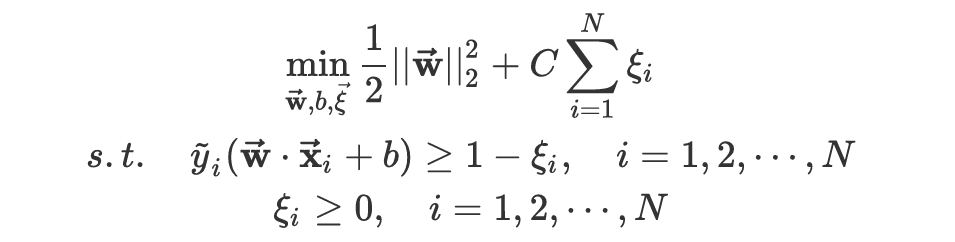

<font size=3>其中C>0为惩罚参数，表示对误分类的惩罚程度。最小化该目标函数可包含两层含义：既要使得间隔最大化也要使得误分类点个数最少，C即为二者的调和系数。

In [3]:
import numpy
from cvxopt import matrix #凸优化求解的第三方库cvxopt实现线性支持向量机
from cvxopt import solvers

In [4]:
# 定义二次规划参数
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]]) #G，h是下面的条件
h = matrix([0.0,0.0,-15.0,100.0,80.0])

In [5]:
# 构建求解
sol = solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.


In [9]:
# 获取最优值
print(sol['x'],sol['primal objective'])

[ 7.13e-07]
[ 5.00e+00]
 20.00000617311241


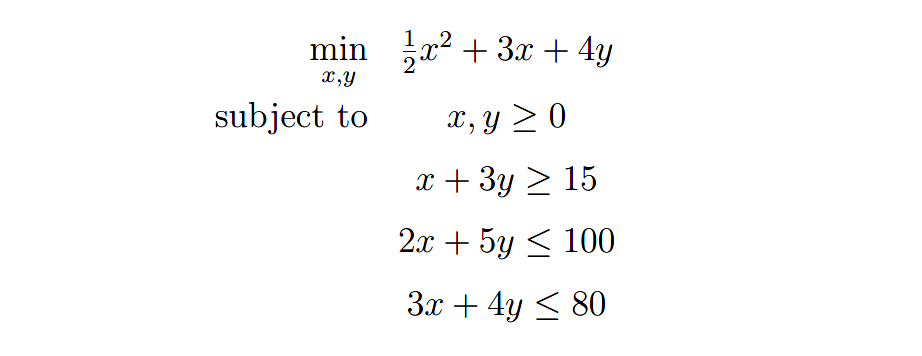

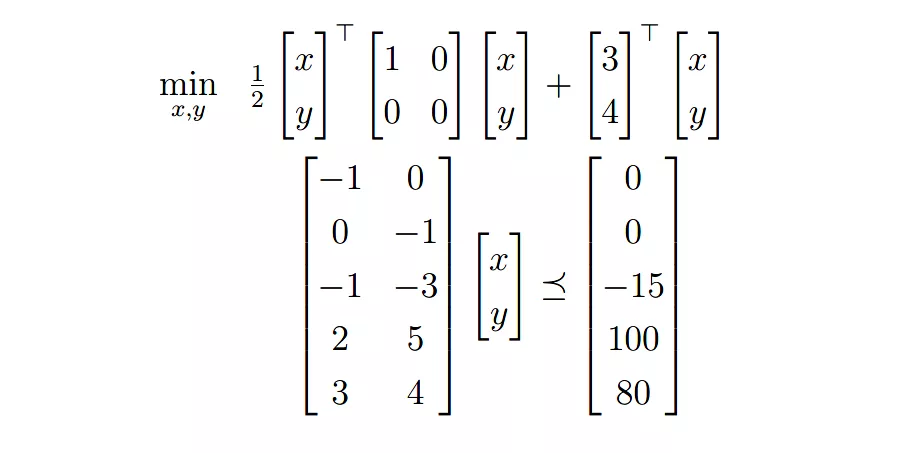

In [10]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl

In [11]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [12]:
def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0, 0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2
    
X1, y1, X2, y2 = gen_non_lin_separable_data()

In [19]:
print(X1[:5])
print(y1[:5])

[[-1.54950657  1.77000956]
 [-1.10478339  1.02148655]
 [-2.21811472  0.64439571]
 [ 0.23202619  2.80913695]
 [-0.24389114  3.15993531]]
[1. 1. 1. 1. 1.]


In [20]:
def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

In [21]:
def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

In [22]:
X_train, y_train = split_train(X1, y1, X2, y2)
X_test, y_test = split_test(X1, y1, X2, y2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(180, 2) (180,) (20, 2) (20,)


In [26]:
X = X_train
n_samples, n_features = X.shape

# Gram matrix
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        K[i, j] = linear_kernel(X[i], X[j])
print(X.shape)
print(K.shape)

(180, 2)
(180, 180)


In [29]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

In [30]:
K[1][20]
K[20][1]

2.6510550092394056

2.6510550092394056

In [34]:
np.outer(y_train, y_train).shape

1.0

1.0

In [ ]:
def fit(X, y, C):
    n_samples, n_features = X.shape

    # Gram matrix
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = linear_kernel(X[i], X[j])

    P = cvxopt.matrix(np.outer(y, y) * K) #outer外积
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1, n_samples))
    b = cvxopt.matrix(0.0)

    if C is None:
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
    else:
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    # solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    a = np.ravel(solution['x'])
    # Support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    a = a[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    print("%d support vectors out of %d points" % (len(a), n_samples))

    # Intercept
    b = 0
    for n in range(len(a)):
        b += sv_y[n]
        b -= np.sum(a * sv_y * K[ind[n], sv])
    b /= len(a)

    # Weight vector
    w = np.zeros(n_features)
    for n in range(len(a)):
        w += a[n] * sv_y[n] * sv[n]
    else:
        w = None